# Práctica 1: Clasificación multi-etiqueta

## Ejercicio 4

Busca en Internet dos datasets extra. Descárgalos localmente y realiza un script en Python para cargarlos y recalcular todas las medidas del paso anterior sobre los mismos. Debes escoger datasets variados, con diferente número de etiquetas, variables e instancias.

### Enfoque

Para realizar este apartado se ha modificado el apartado anterior pero en vez de ejecutar las funciones sobre todos los conjuntos de datos se han descargado dos conjuntos de datos desde la página de la que se sacó la información de los Datasets anteriores, [Multi-Label Classification Dataset Repository](www.uco.es/kdis/mllresources/). Se han buscado dos datasets que no hayan sido utilizados anteriormente, de naturalezas diferentes y con características diferentes. Los datasets seleccionados son:
- Flags
- Yahoo_Science

Se han seleccionado estos conjuntos de datos porque su información está almacenada en ficheros ARFF, y la librería multilearn contiene una función para cargar este tipo de ficheros.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from skmultilearn.dataset import load_from_arff

# Calculos
from scipy.stats import chi2_contingency

In [35]:
# Unzip folders from Practica1/4. DatasetsExtra/
import zipfile
import os
import shutil

PATH = "4. DatasetsExtra/"

for file in os.listdir(PATH):
    if file.endswith(".zip"):
        with zipfile.ZipFile(PATH + file, 'r') as zip_ref:
            # Extract all the contents of each zip on a folder with the same name as the zip
            zip_ref.extractall(PATH + file.split(".zip")[0])
            print("Unzipped: ", file)


Unzipped:  Flags.zip
Unzipped:  Yahoo.zip


### Carga de conjuntos de datos desde los ficheros

#### [Fichero ARFF](http://scikit.ml/datasets.html#ARFF-files)

Siguiendo la documentación se indica el código necesario para realizar una carga de un conjunto de datos desde un fichero ARFF, sin embargo, hay que tener información de este conjunto de datos para cargarlo con la función facilitada por la librería scikit-multilearn.

Estos datos son:
- `path`: ruta del archivo arff
- `label_count`: número de etiquetas
- `label_location`: se deja el valor que nos da la documentación
- `load_sparse`: se deja el valor que nos da la documentación

Para el conjunto de datos de Yahoo_Science el `label_count` obtener yendo al fichero arff y contando el número de etiquetas, al estar nombreadas como Label y enumeradas del 1 al 40 en este caso, es fácil saber que contamos con 40 etiquetas.

Por otro lado el conjunto Flags no es tan sencillo, tiene menos atributos y etiquetas, pero no viene indicado en el nombre qué es un conjunto y qué es un etiqueta. Por eso requiere una búsqueda más exhaustiva de información. La misma página desde donde se han obtenido los datos contiene una tabla con los estadísticos e información sobre el conjunto de datos. El conjunto de datos flags tiene el valor 7 en q (número de labels). Y mirando Yahoo_science confirma que tiene 40.

In [37]:
path_to_arff_file = "4. DatasetsExtra/Yahoo/Science1.arff"
label_location="end"
label_count=40
arff_file_is_sparse = False

X_Science, y_Science, feature_names_Science, label_names_Science = load_from_arff(
    path_to_arff_file,
    label_count=label_count,
    label_location=label_location,
    load_sparse=arff_file_is_sparse,
    return_attribute_definitions=True
)

path_to_arff_file = "4. DatasetsExtra/Flags/flags.arff"
label_location="end"
label_count=7
arff_file_is_sparse = False

X_Flags, y_Flags, feature_names_Flags, label_names_Flags = load_from_arff(
    path_to_arff_file,
    label_count=label_count,
    label_location=label_location,
    load_sparse=arff_file_is_sparse,
    return_attribute_definitions=True
)

### Funciones para visualizar los conjuntos de datos

- `get_dataset_info`: Muestra información general del conjunto de datos para conocer sus dimensiones y nombres de las etiquetas.
- `visualize_label_number`: Muestra en un gráfico el número de etiquetas que tiene cada instancia, también muestra la media de etiquetas por instancia. Es una gráfica que permite comprobar el nivel de multietiqueta de cada conjunto.

#### Funciones de cálculo de estadísticos
- `calculate_diversity`: Calcula la diversidad, calculando los labelsets existentes en el conjunto entre el número de labelsets posibles. Siendo un labelset las combinaciones de etiquetas que puede tener una instancia. [2]
- `calculate_avgir`: Calcula el Average Imbalance Ratio, que es una métrica que mide el grado medio de desequilibrio de todas las etiquetas [1]
- `calculate_rdep`: Calcula la proporción de pares de etiquetas que son dependientes con un 99 % de confianza según chi cuadrado. [2]


[1] Tarekegn, A. N., Giacobini, M., & Michalak, K. (2021). A review of methods for imbalanced multi-label classification. Pattern Recognition, 118, 107965.

[2] https://github.com/i02momuj/MLDA/blob/master/doc/MLDA_Doc.pdf

In [52]:
def calculate_diversity(y):
    df_labels = pd.DataFrame(y.toarray())
    unique_label_sets = set(df_labels.apply(tuple, axis=1))
    num_unique_label_sets = len(unique_label_sets)

    num_possible_label_sets = 2 ** y.shape[1]

    diversity = (num_unique_label_sets / num_possible_label_sets)

    return diversity

def calculate_avgir(y):
    dense_labels = y.toarray()

    label_frequencies = pd.Series(dense_labels.sum(axis=0))
    max_frequency = label_frequencies.max()

    # Imbalance Ratio de cada clase
    ir_interclass = max_frequency / label_frequencies
    # Media de los Imbalance Ratio
    mean_ir_interclass = ir_interclass.mean()

    return mean_ir_interclass

def calculate_rdep(y):
    # ratio of unconditionally dependent label pairs by chi-square test 
    # (rDep, measures the proportion of pairs of labels that are dependent 
    # at 99% confidence)
    df_labels = pd.DataFrame(y.toarray())
    num_labels = y.shape[1]
    rdep = 0
    for i in range(num_labels):
        for j in range(i+1, num_labels):
            observed = pd.crosstab(df_labels[i], df_labels[j])
            chi2, p, dof, expected = chi2_contingency(observed)
            if p < 1 - 0.99:
                rdep += 1
    rdep /= (num_labels * (num_labels - 1) / 2)
    return rdep

In [53]:
def get_dataset_info(dataset, X, y, label_names):
    
    k = y.shape[1]

    print('Número de instancias en {}: {}'.format(dataset, X.shape[0]))
    print('Número de atributos en {}: {}'.format(dataset, X.shape[1]))
    print('Número de etiquetas en {}: {}'.format(dataset, k))
    
    # Cardinalidad
    cardinality = np.mean(np.sum(y, axis=1))
    print('Car en {}: {}'.format(dataset, cardinality))
    
    # Densidad
    density = cardinality / k
    print('Den en {}: {}'.format(dataset, density))
    
    # Diversidad
    diversity = calculate_diversity(y)
    print('Div en {}: {}'.format(dataset, diversity))
    
    # AvgIR (Average Imbalance Ratio)
    avgIR = calculate_avgir(y)
    print('AvgIR en {}: {}'.format(dataset, avgIR))
    
    # rDep (Ratio of unconditionally dependent label pairs by chi-square test)
    rDep = calculate_rdep(y)
    print('rDep en {}: {}'.format(dataset, rDep))
    
    print("\n")
    print("\n")
    
    # Información extra
    print('Nombres de etiquetas en {}: \n{}'.format(dataset, label_names))

In [54]:
# Visualizar para cada conjunto de datos
def visualize_label_number(dataset, y):

    # Obtener el número de etiquetas por instancia
    labels_per_instance = np.sum(y, axis=1)

    # Mostrar histograma
    plt.hist(labels_per_instance, bins=range(0, 30, 1))

    # Agregar la media como texto
    plt.text(0.5, 0.95, f'Media de etiquetas por instancia: {np.mean(labels_per_instance):.2f}', ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    plt.title(dataset)
    plt.xlabel('Número de etiquetas por instancia')
    plt.ylabel('Número de instancias')
    plt.show()

    # Mostrar media
    #print('Media de etiquetas por instancia en {}: {}'.format(dataset, np.mean(labels_per_instance)))

#### [Flags](https://www.uco.es/kdis/mllresources/#Flags)

Este conjunto de datos contiene detalles de algunos países y sus banderas, y el objetivo es predecir algunas de las características. El conjunto de datos se utilizó por primera vez para la clasificación de etiquetas múltiples en [Gonçalves et al. 2013].

Número de instancias en Flags: 194
Número de atributos en Flags: 19
Número de etiquetas en Flags: 7
Car en Flags: 3.3917525773195876
Den en Flags: 0.4845360824742268
Div en Flags: 0.421875
AvgIR en Flags: 2.2547085986420625
rDep en Flags: 0.3333333333333333




Nombres de etiquetas en Flags: 
[('red', ['0', '1']), ('green', ['0', '1']), ('blue', ['0', '1']), ('yellow', ['0', '1']), ('white', ['0', '1']), ('black', ['0', '1']), ('orange', ['0', '1'])]


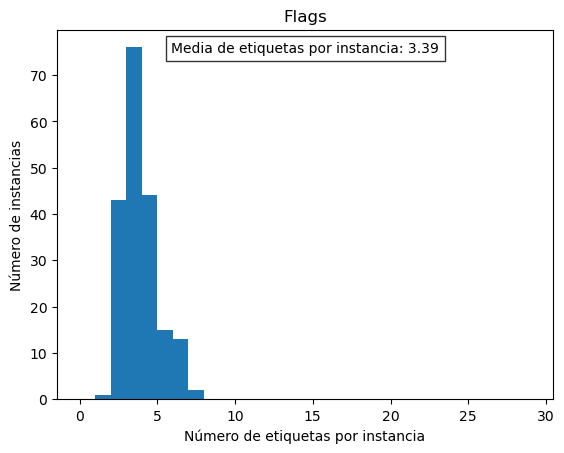

In [55]:
get_dataset_info("Flags", X_Flags, y_Flags, label_names_Flags)

visualize_label_number("Flags", y_Flags)

#### [Yahoo_Science](https://www.uco.es/kdis/mllresources/#YahooDesc)

Es un subconjunto que pertenece al conjunto Yahoo. Yahoo es un conjunto de datos para categorizar páginas web y consta de 14 categorías de primer nivel, cada una de ellas está clasificada en una serie de categorías de segundo nivel. Al centrarse en categorías de segundo nivel, se utilizaron 11 de los 14 problemas de categorización de textos independientes. La categoría a la que pertenece este conjunto de datos Yahoo_Science es Science.

Número de instancias en Yahoo_Science: 6428
Número de atributos en Yahoo_Science: 37187
Número de etiquetas en Yahoo_Science: 40
Car en Yahoo_Science: 1.4497510889856877
Den en Yahoo_Science: 0.03624377722464219
Div en Yahoo_Science: 4.156390787102282e-10
AvgIR en Yahoo_Science: 52.63176803901005
rDep en Yahoo_Science: 0.2358974358974359




Nombres de etiquetas en Yahoo_Science: 
[('Label1', ['0', '1']), ('Label2', ['0', '1']), ('Label3', ['0', '1']), ('Label4', ['0', '1']), ('Label5', ['0', '1']), ('Label6', ['0', '1']), ('Label7', ['0', '1']), ('Label8', ['0', '1']), ('Label9', ['0', '1']), ('Label10', ['0', '1']), ('Label11', ['0', '1']), ('Label12', ['0', '1']), ('Label13', ['0', '1']), ('Label14', ['0', '1']), ('Label15', ['0', '1']), ('Label16', ['0', '1']), ('Label17', ['0', '1']), ('Label18', ['0', '1']), ('Label19', ['0', '1']), ('Label20', ['0', '1']), ('Label21', ['0', '1']), ('Label22', ['0', '1']), ('Label23', ['0', '1']), ('Label24', ['0', '1']), ('Label25', ['0', '1']),

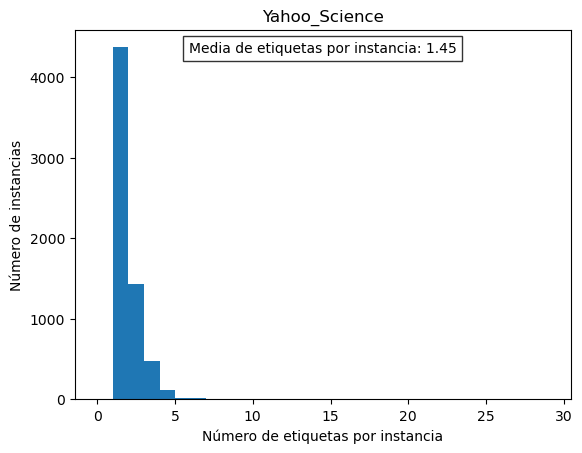

In [43]:
dataset_name = "Yahoo_Science"

get_dataset_info("Yahoo_Science", X_Science, y_Science, label_names_Science)

visualize_label_number("Yahoo_Science", y_Science)

En este apartado se ha aprendido a realizar una carga de datos un poco más compleja, así, se pueden realizar clasificaciones y predicciones sobre nuevos conjuntos de datos y no sólo sobre aquellos que pertenecen y están almacenados en la libería scikit-multilearn, que puede llegar a ser limitante.

En concreto sólo se han importado conjuntos de datos almacenados en formato ARFF por la facilidad que da la librería usada en la práctica para importar este tipo de ficheros, sin embargo, también sería posible importar conjunto de datos con otro tipo de estructura en los ficheros, pero su implementacón podría ser más complicada y requerir otro tipo de librerías.